# Pathfinding Exploration

- DFS
- BFS
- IDDFS (removed completely)
- A-star

In [307]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

from utils.search import bfs, dfs, dfs_heuristic, greedy_bfs, a_star
from utils.graph import Graph
from utils.plots import plot_grid, plot_path

## A simple example of N = 1

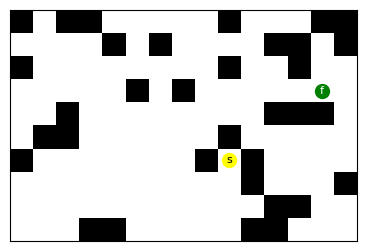

In [258]:
percent_blockage = 0.25

graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

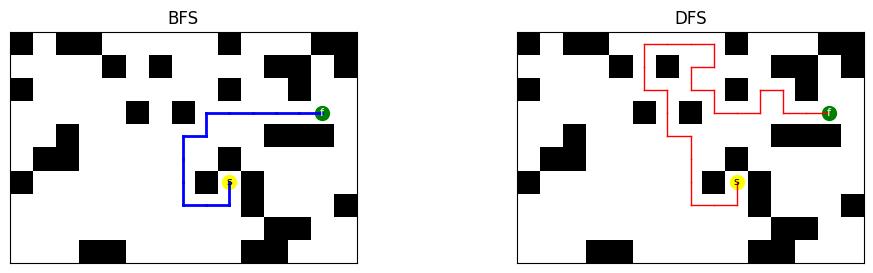

BFS:
Time: 0.0001537799835205078 (s)
# Iteractions: 87
Path length: 13

DFS:
Time: 6.699562072753906e-05 (s)
# Iteractions: 40
Path length: 27


In [260]:
bfs_path, bfs_complexity = graph.search(bfs)
dfs_path, dfs_complexity = graph.search(dfs)

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], dfs_path, c='red',label='DFS')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

### Let's see this interactively

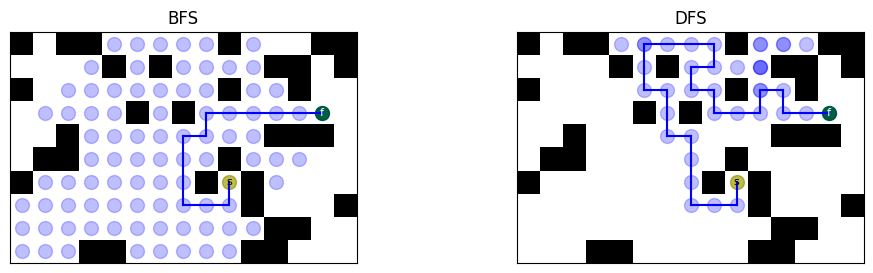

In [262]:
bfs_generator = graph.search_generator(bfs)
dfs_generator = graph.search_generator(dfs)

generators = [bfs_generator, dfs_generator]

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("DFS")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

## Let's do this many times and compare.

Important to note that as the `percent_blockage` gets to a certain point, there tends to become less and less available paths (and neighbors), so we see some convergence between methods. I'll stop it by a certain point, as we're guaranteeing an existing path, so going beyond a certain `percent_blockage` becomes redundant.

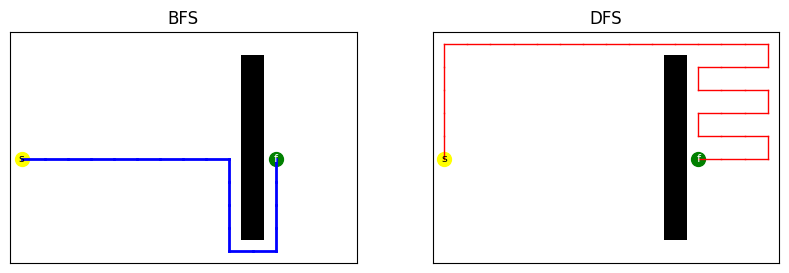

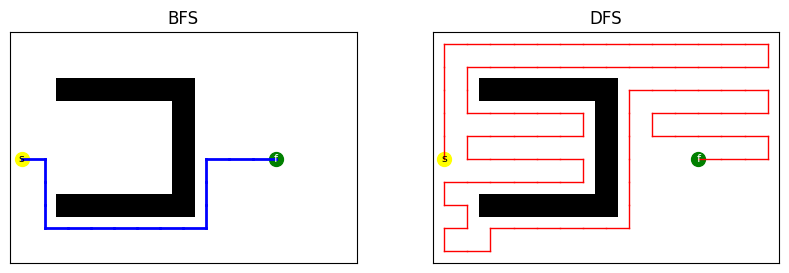

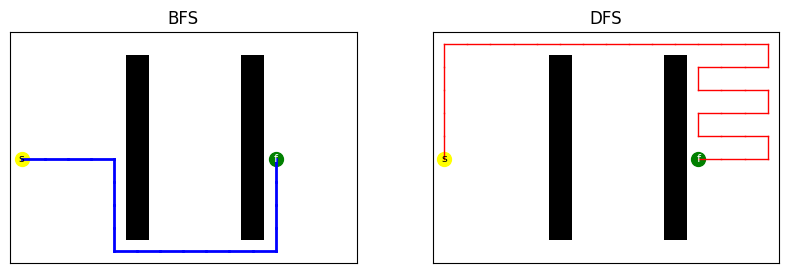

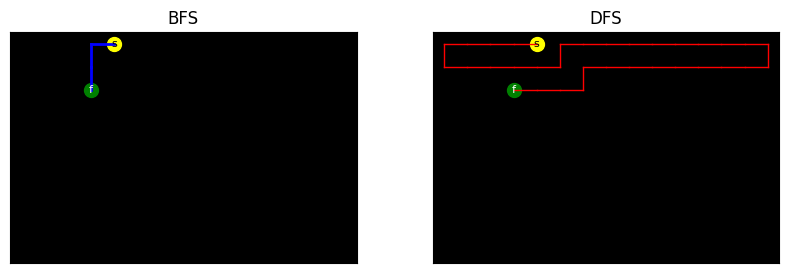

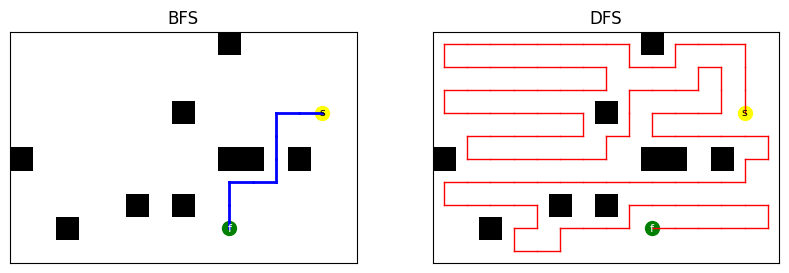

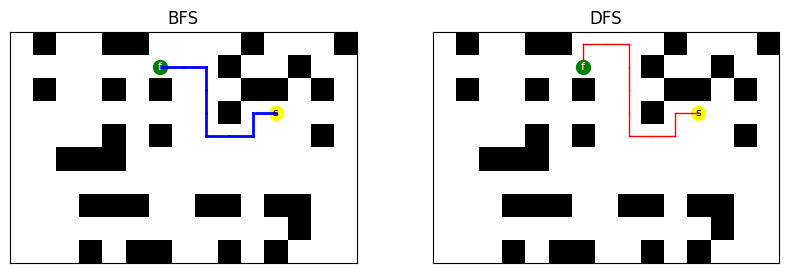

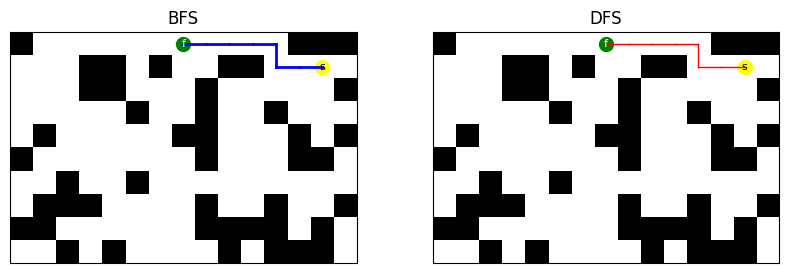

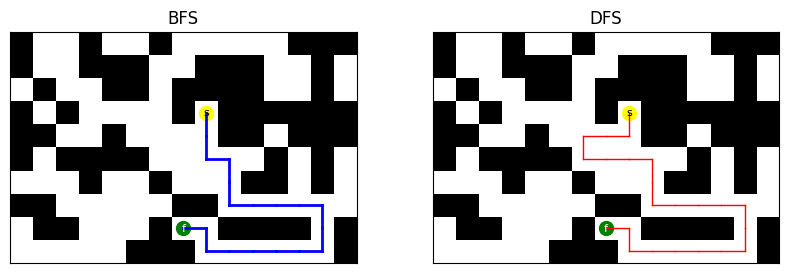

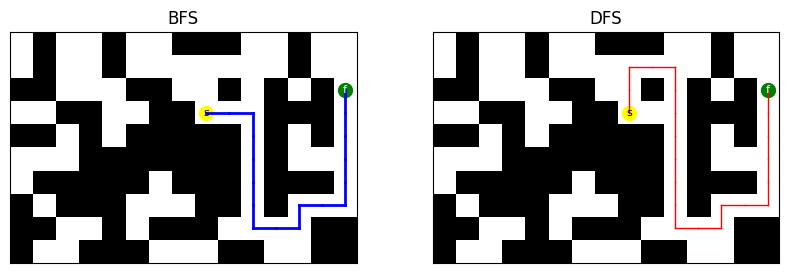

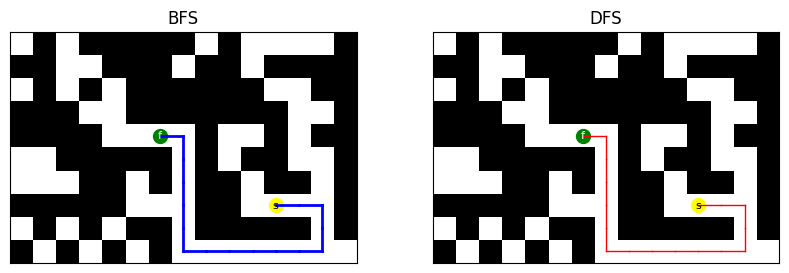

In [263]:
n = 1_000

datas = []
percent_blockages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)
    bfs_path, bfs_complexity = graph.search(bfs)
    dfs_path, dfs_complexity = graph.search(dfs)

    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["dfs"]["time"] = dfs_complexity["time"]
    data["dfs"]["iterations"] = dfs_complexity["iterations"]
    data["dfs"]["length"] = dfs_complexity["length"]

    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], dfs_path, c='red',label='DFS')

    plt.show()

    datas.append(data)

for percent in percent_blockages:
    data = {
        "percent": percent,
        "type": "random",
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
    }
    for i in range(n):
        graph.generate_grid(grid_type="random", percent_blocked=percent)
        bfs_path, bfs_complexity = graph.search(bfs)
        dfs_path, dfs_complexity = graph.search(dfs)

        data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
        data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
        data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

        data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
        data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
        data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)
    
    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS', linewidth=2)
    plot_path(axes[1], dfs_path, c='red',label='DFS', linewidth=1)

    plt.show()

    datas.append(data)


In [264]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "dfs"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [265]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time           iterations           length         
                      bfs       dfs        bfs      dfs     bfs      dfs
percent type                                                            
0.0     fixed_0  0.000232  0.000051    123.000   40.000  19.000   39.000
        fixed_1  0.000211  0.000118    111.000  102.000  17.000  101.000
        fixed_2  0.000211  0.000051    115.000   40.000  19.000   39.000
        random   0.000138  0.000087     77.530   77.719   8.473   73.629
0.1     random   0.000118  0.000085     68.286   77.760   8.514   58.236
0.2     random   0.000107  0.000083     62.856   76.956   9.586   44.002
0.3     random   0.000090  0.000079     52.235   71.578  11.506   29.090
0.4     random   0.000073  0.000066     42.358   59.768  13.198   20.616
0.5     random   0.000059  0.000046     33.796   41.721  15.031   18.169
0.6     random   0.000044  0.000032     25.165   29.014  14.390   15.710

# Adding heuristics to search

Right now selecting a neighbor has equivalent "cost". We know where the starting + end locations are located, so can we use this information?

Rather than BFS / DFS randomly traversing the space, let's intro some heuristics.

Doing this will also introduce a new Data Structure `Priority Queue`. Rather than simply using a queue, we can sort it based on some priority given a heuristic.

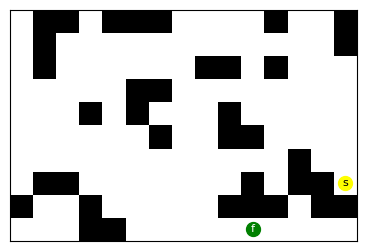

In [267]:
percent_blockage = 0.25
graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

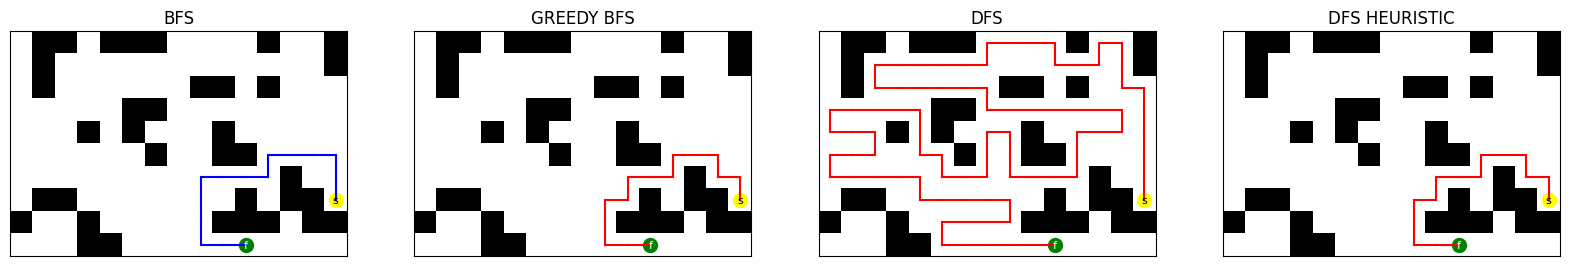

BFS:
Time: 0.0001571178436279297 (s)
# Iteractions: 73
Path length: 14

GREEDY BFS:
Time: 5.6743621826171875e-05 (s)
# Iteractions: 16
Path length: 14

DFS:
Time: 0.00013399124145507812 (s)
# Iteractions: 115
Path length: 84

DFS HEURISTIC:
Time: 3.886222839355469e-05 (s)
# Iteractions: 15
Path length: 14


In [268]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
dfs_path, dfs_complexity = graph.search(dfs)
dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], dfs_path, c='red',label='DFS')
plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

plt.show()


print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

print()
print("DFS HEURISTIC:")
print("Time:", dfs_heur_complexity["time"], "(s)")
print("# Iteractions:", dfs_heur_complexity["iterations"])
print("Path length:", dfs_heur_complexity["length"])

### Again, let's see this interactively to how the heuristic behaves

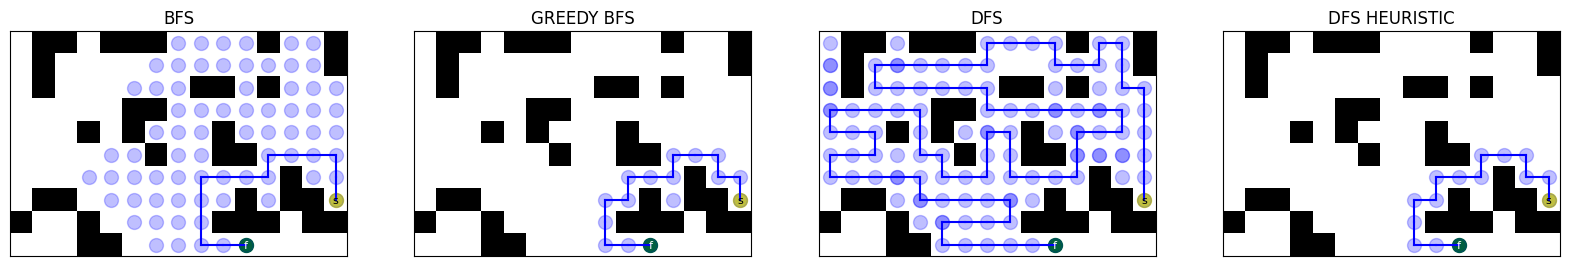

In [269]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)

generators = [bfs_generator, greedy_bfs_generator, dfs_generator, dfs_heur_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("DFS")
    axes[3].set_title("DFS HEURISTIC")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

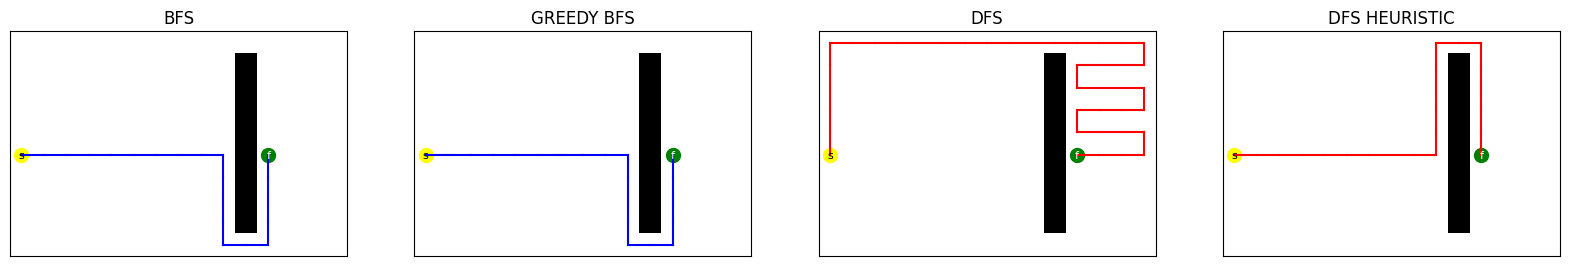

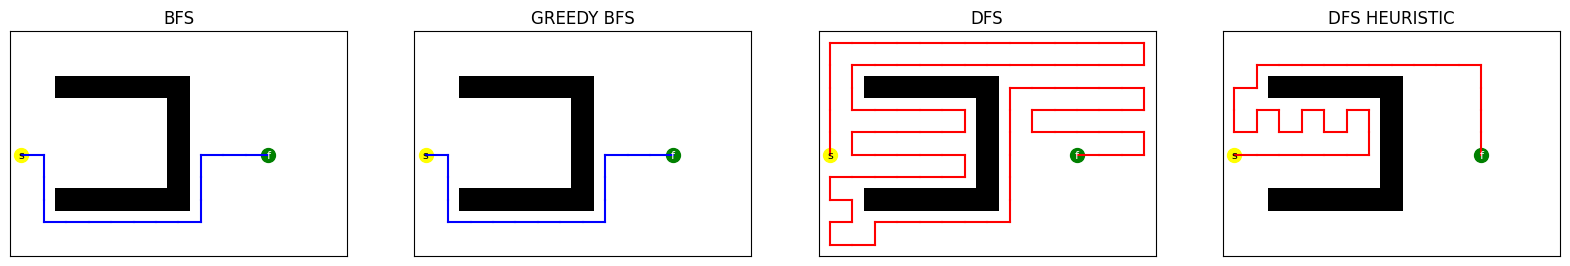

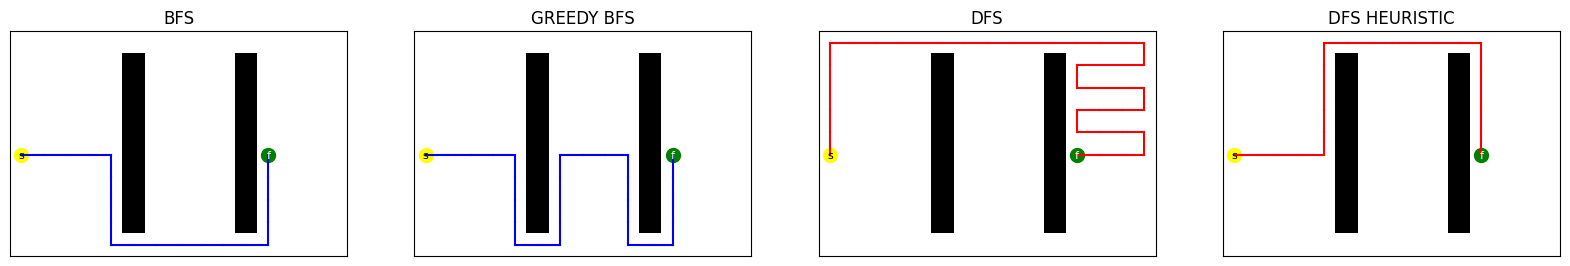

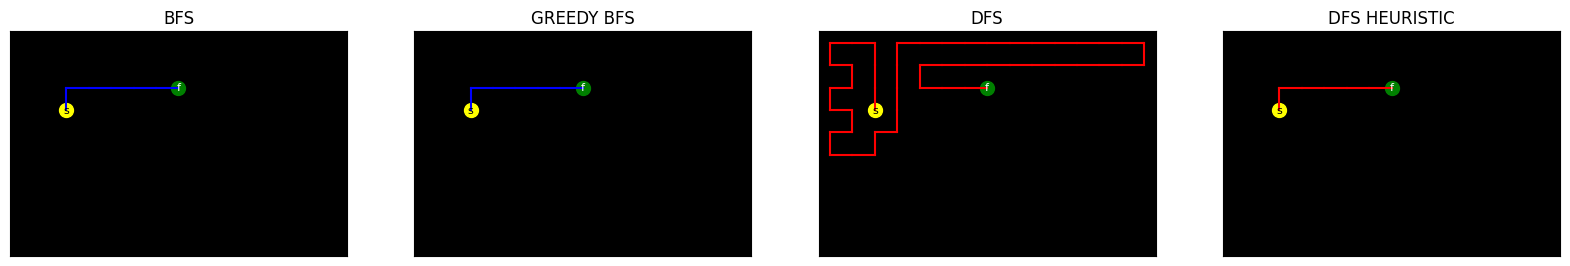

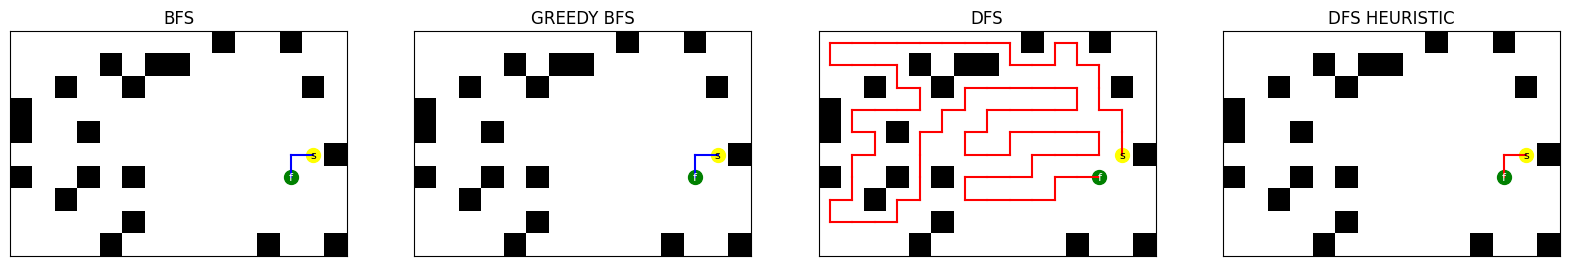

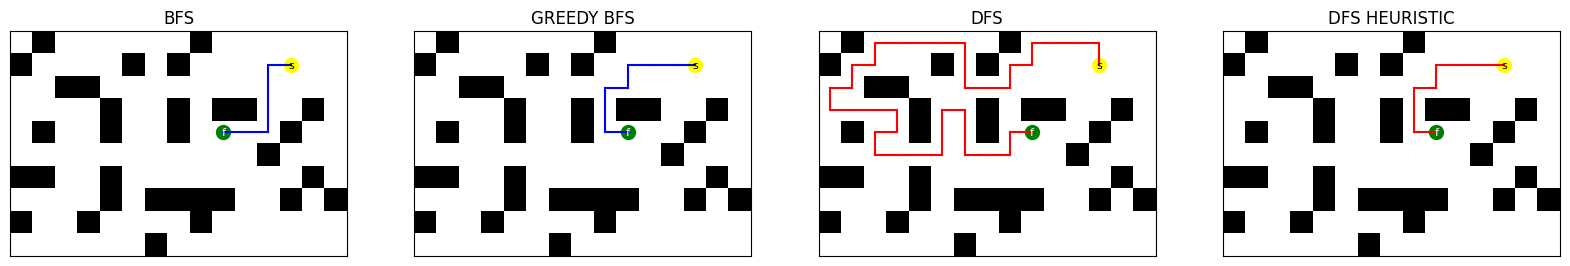

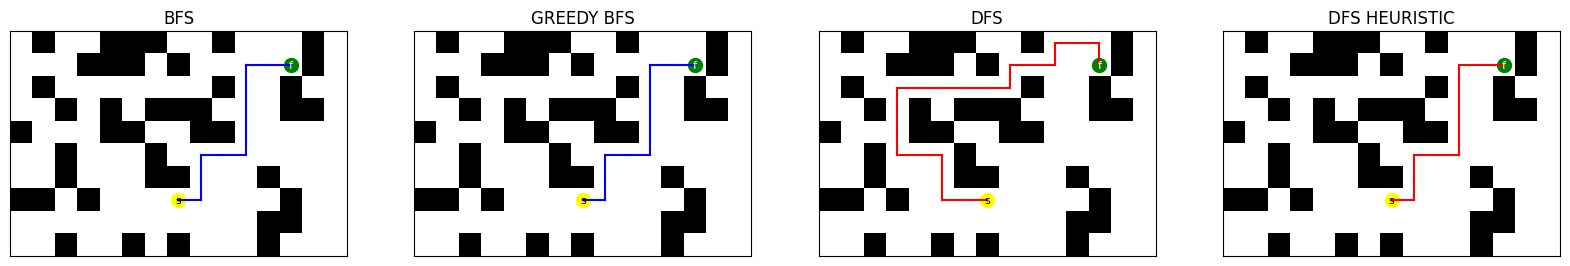

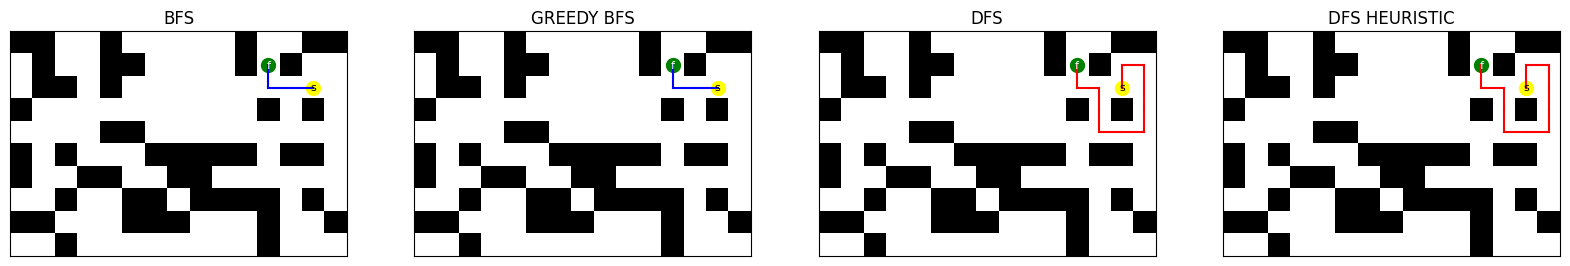

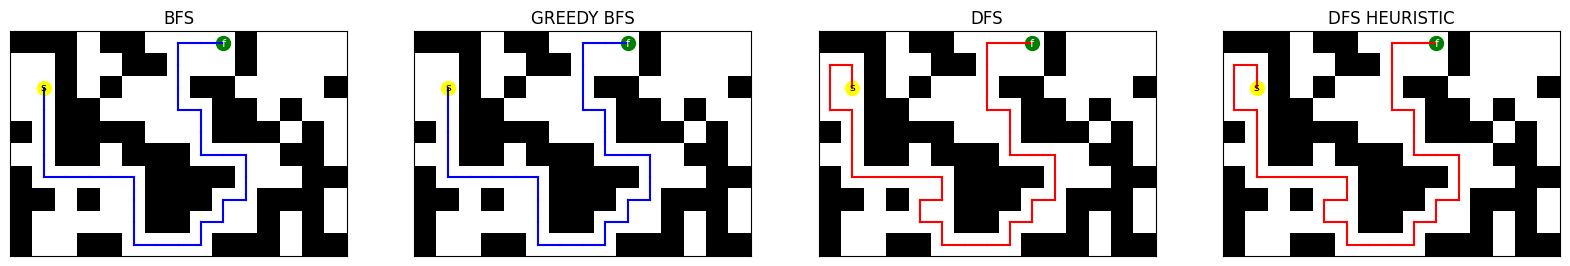

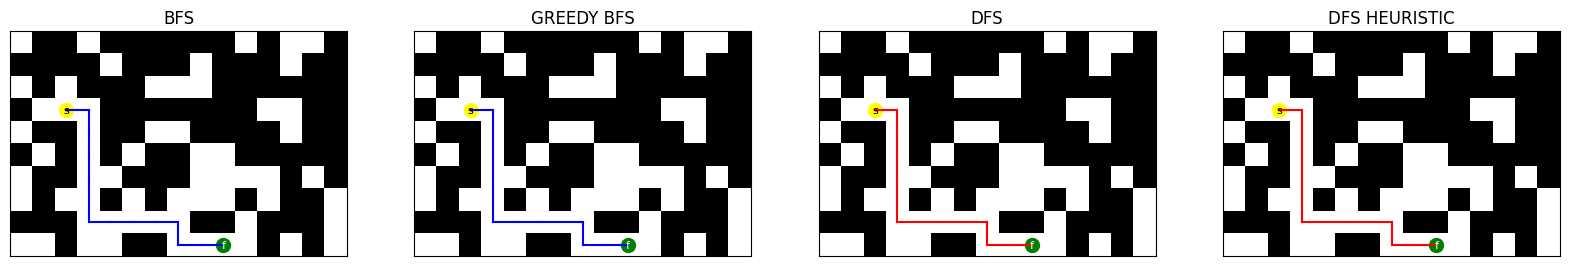

In [271]:
n = 1_000

datas = []
percent_blockages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    dfs_path, dfs_complexity = graph.search(dfs)
    dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
    data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
    data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

    data["dfs"]["time"] = dfs_complexity["time"]
    data["dfs"]["iterations"] = dfs_complexity["iterations"]
    data["dfs"]["length"] = dfs_complexity["length"]

    data["dfs_heur"]["time"] = dfs_heur_complexity["time"]
    data["dfs_heur"]["iterations"] = dfs_heur_complexity["iterations"]
    data["dfs_heur"]["length"] = dfs_heur_complexity["length"]

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], dfs_path, c='red',label='DFS')
    plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

    plt.show()

    datas.append(data)

for percent in percent_blockages:
    data = {
        "percent": percent,
        "type": "random",
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
    }
    for i in range(n):
        graph.generate_grid(grid_type="random", percent_blocked=percent)

        bfs_path, bfs_complexity = graph.search(bfs)
        greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
        dfs_path, dfs_complexity = graph.search(dfs)
        dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)

        data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
        data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
        data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

        data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
        data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
        data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

        data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
        data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
        data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

        data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
        data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
        data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], dfs_path, c='red',label='DFS')
    plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

    plt.show()

    datas.append(data)


In [272]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "greedy_bfs", "dfs", "dfs_heur"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [273]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                iterations  \
                      bfs greedy_bfs       dfs  dfs_heur        bfs   
percent type                                                          
0.0     fixed_0  0.000239   0.000098  0.000051  0.000055    123.000   
        fixed_1  0.000206   0.000105  0.000117  0.000082    111.000   
        fixed_2  0.000218   0.000135  0.000050  0.000049    115.000   
        random   0.000138   0.000030  0.000085  0.000020     79.179   
0.1     random   0.000121   0.000030  0.000085  0.000024     69.967   
0.2     random   0.000104   0.000031  0.000084  0.000033     60.305   
0.3     random   0.000090   0.000039  0.000077  0.000050     52.350   
0.4     random   0.000075   0.000045  0.000067  0.000058     43.523   
0.5     random   0.000056   0.000042  0.000046  0.000050     32.467   
0.6     random   0.000044   0.000038  0.000033  0.000041     25.286   

                                              length                      \
                greedy_bfs      dfs dfs_heur     bfs greedy_bfs      dfs   
percent type                                                               
0.0     fixed_0     36.000   40.000   22.000  19.000     19.000   39.000   
        fixed_1     45.000  102.000   38.000  17.000     17.000  101.000   
        fixed_2     59.000   40.000   22.000  19.000     27.000   39.000   
        random       9.663   77.405    9.663   8.663      8.663   73.381   
0.1     random      10.393   79.305   12.153   8.767      9.081   59.963   
0.2     random      11.951   77.962   17.494   9.332      9.816   43.752   
0.3     random      17.008   70.620   27.708  11.482     11.944   28.354   
0.4     random      21.335   61.038   32.390  13.584     13.946   21.350   
0.5     random      20.991   41.112   28.540  14.356     14.518   17.488   
0.6     random      19.706   29.351   23.499  14.715     14.773   16.061   

                          
                dfs_heur  
percent type              
0.0     fixed_0   21.000  
        fixed_1   37.000  
        fixed_2   21.000  
        random     8.663  
0.1     random    10.169  
0.2     random    12.300  
0.3     random    14.568  
0.4     random    16.054  
0.5     random    15.674  
0.6     random    15.539

## Let's add another algorithm, but introduce costs.

A* algorithm is used here. The heuristic gave us some speed ups, but it isn't guaranteed to find the optimal path. We'll introduce costs here.

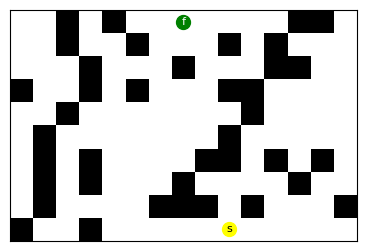

In [275]:
percent_blockage = 0.25

graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

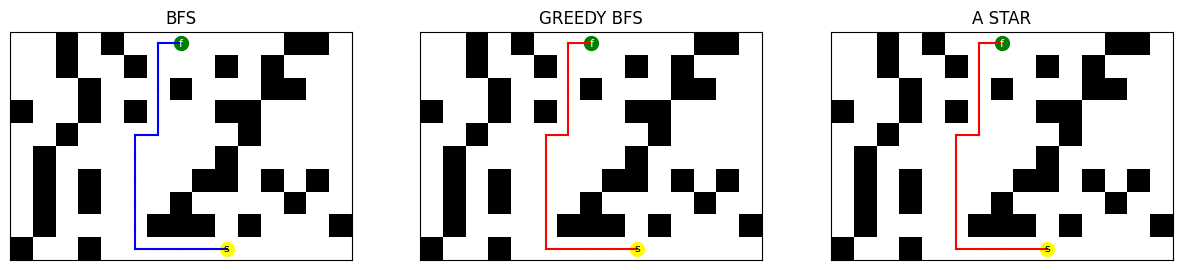

BFS:
Time: 0.00018525123596191406 (s)
# Iteractions: 88
Path length: 15

GREEDY BFS:
Time: 9.894371032714844e-05 (s)
# Iteractions: 41
Path length: 15

A STAR:
Time: 7.009506225585938e-05 (s)
# Iteractions: 27
Path length: 15


In [276]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
astar_path, astar_complexity = graph.search(a_star)

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], astar_path, c='red',label='A STAR')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("A STAR:")
print("Time:", astar_complexity["time"], "(s)")
print("# Iteractions:", astar_complexity["iterations"])
print("Path length:", astar_complexity["length"])

### Let's see it in action

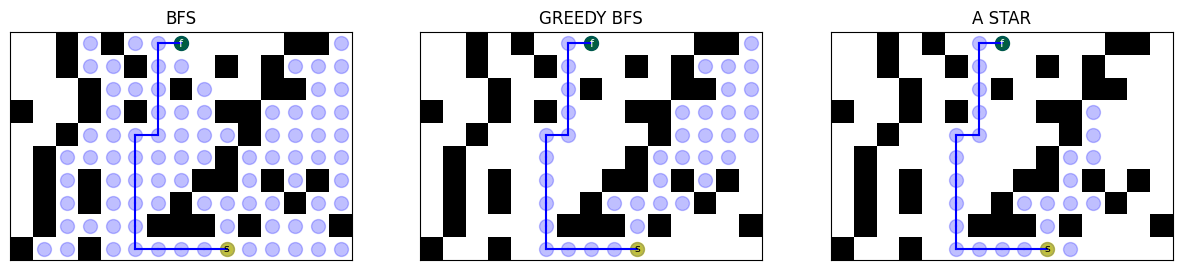

In [277]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

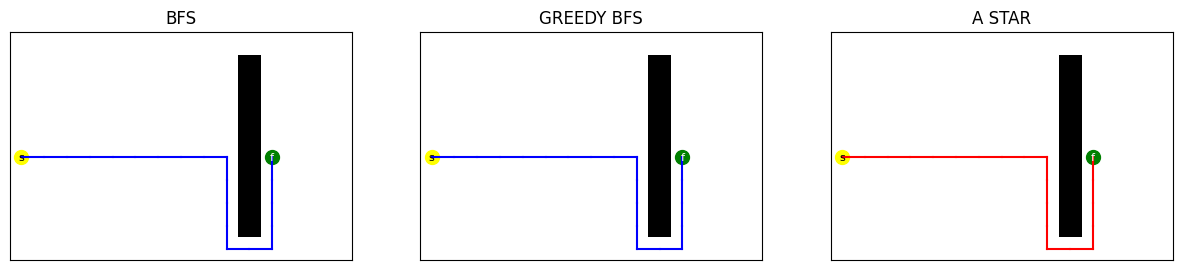

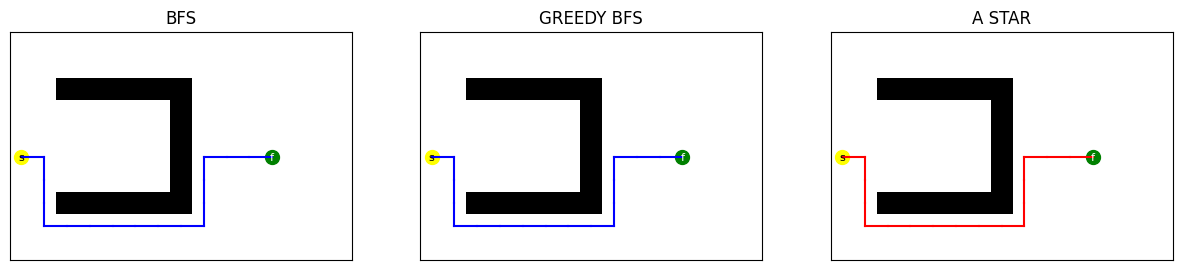

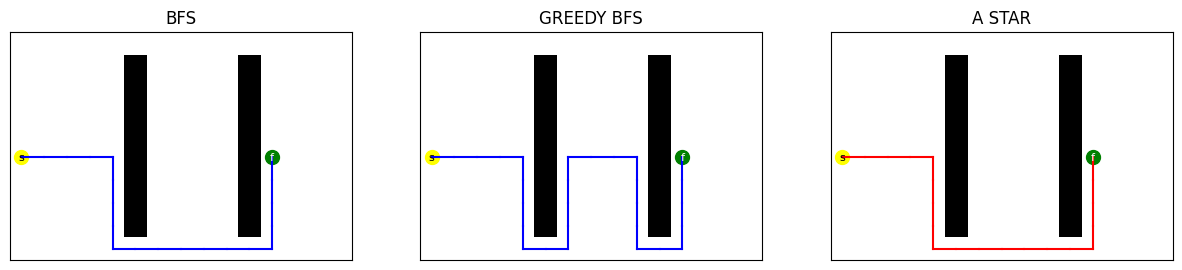

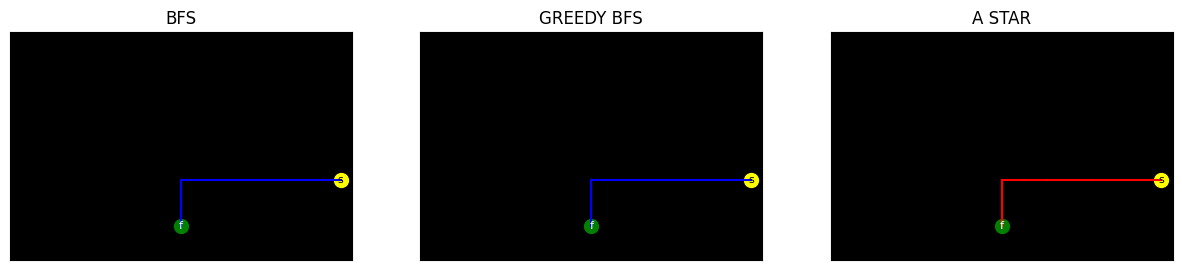

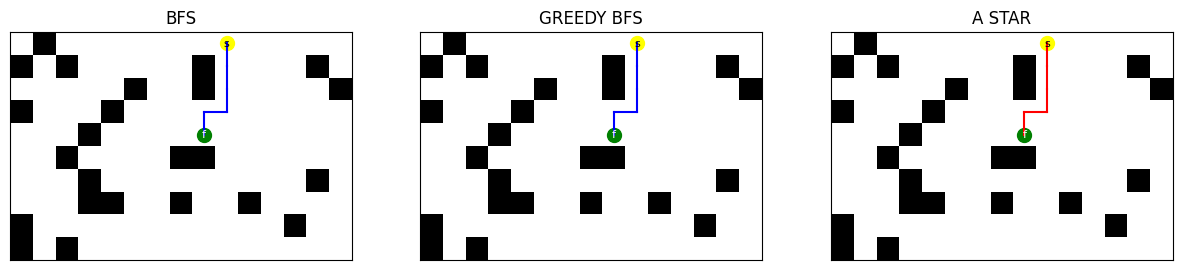

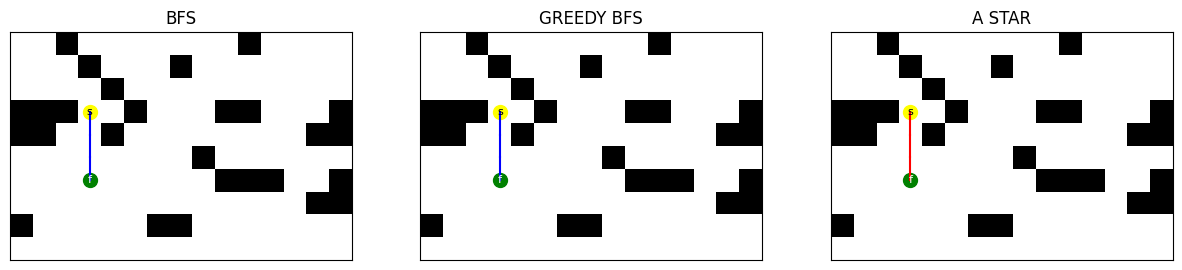

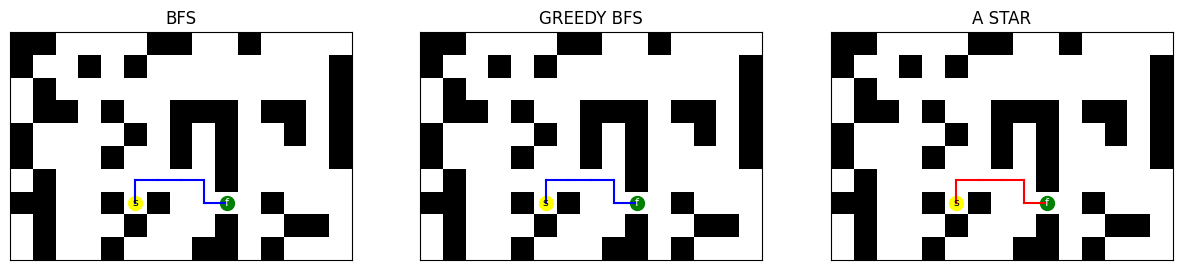

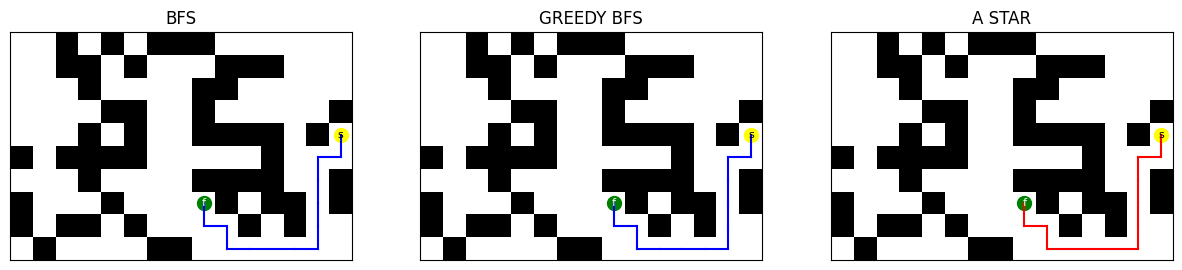

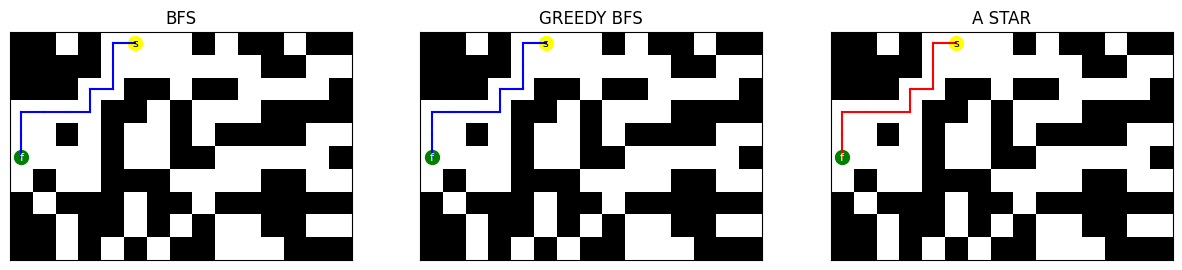

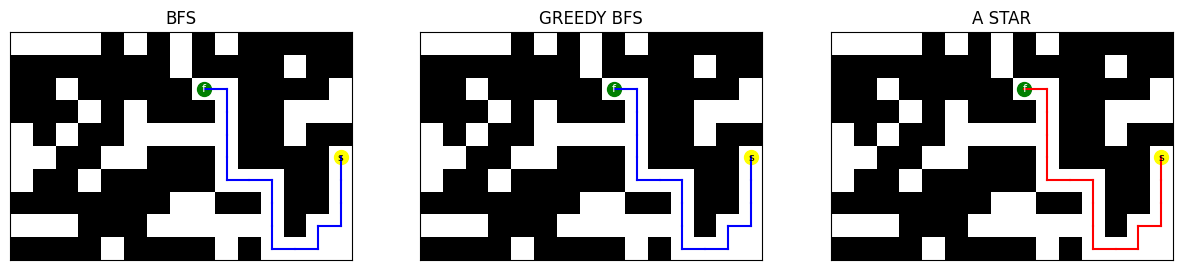

In [279]:
n = 1_000

datas = []
percent_blockages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "a_star": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    astar_path, astar_complexity = graph.search(a_star)

    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
    data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
    data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

    data["a_star"]["time"] = astar_complexity["time"]
    data["a_star"]["iterations"] = astar_complexity["iterations"]
    data["a_star"]["length"] = astar_complexity["length"]

    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], astar_path, c='red',label='A STAR')

    plt.show()

    datas.append(data)

for percent in percent_blockages:
    data = {
        "percent": percent,
        "type": "random",
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "a_star": {"time": 0, "iterations": 0, "length": 0},
    }
    for i in range(n):
        graph.generate_grid(grid_type="random", percent_blocked=percent)

        bfs_path, bfs_complexity = graph.search(bfs)
        greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
        astar_path, astar_complexity = graph.search(a_star)

        data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
        data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
        data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

        data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
        data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
        data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

        data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
        data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
        data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)


    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], astar_path, c='red',label='A STAR')

    plt.show()

    datas.append(data)


In [280]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "greedy_bfs", "a_star"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [281]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                      iterations                     \
                      bfs greedy_bfs    a_star        bfs greedy_bfs  a_star   
percent type                                                                   
0.0     fixed_0  0.000219   0.000090  0.000194    123.000     36.000  96.000   
        fixed_1  0.000215   0.000106  0.000116    111.000     45.000  47.000   
        fixed_2  0.000221   0.000137  0.000162    115.000     59.000  72.000   
        random   0.000139   0.000031  0.000048     79.450      9.678  17.555   
0.1     random   0.000120   0.000030  0.000042     69.359     10.379  15.980   
0.2     random   0.000108   0.000033  0.000045     63.535     12.773  18.667   
0.3     random   0.000092   0.000040  0.000051     53.335     17.438  23.041   
0.4     random   0.000075   0.000045  0.000053     42.984     21.184  25.315   
0.5     random   0.000057   0.000043  0.000047     32.939     21.502  23.394   
0.6     random   0.000044   0.000038  0.000040     24.673     19.029  20.109   

                 length                     
                    bfs greedy_bfs  a_star  
percent type                                
0.0     fixed_0  19.000     19.000  19.000  
        fixed_1  17.000     17.000  17.000  
        fixed_2  19.000     27.000  19.000  
        random    8.678      8.678   8.678  
0.1     random    8.683      9.023   8.683  
0.2     random    9.755     10.221   9.755  
0.3     random   11.498     11.974  11.498  
0.4     random   13.752     14.100  13.752  
0.5     random   14.432     14.590  14.432  
0.6     random   14.341     14.407  14.341

# Exhaustive Search

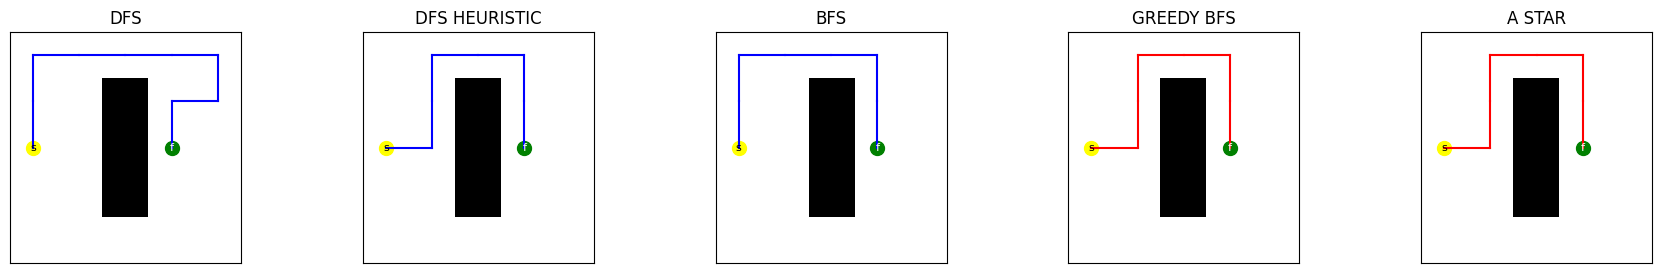

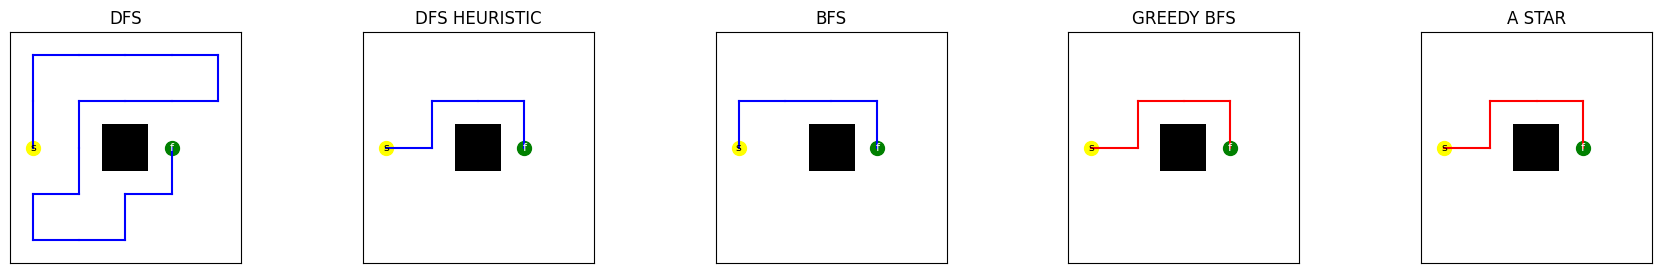

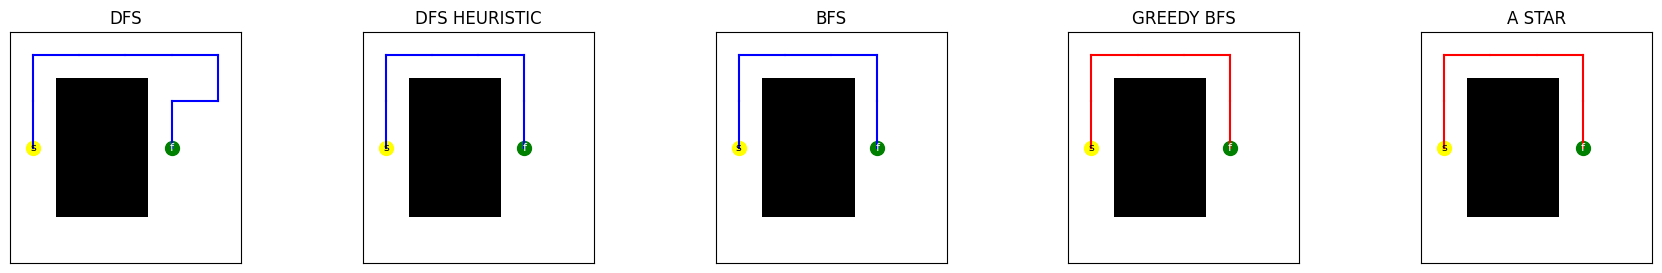

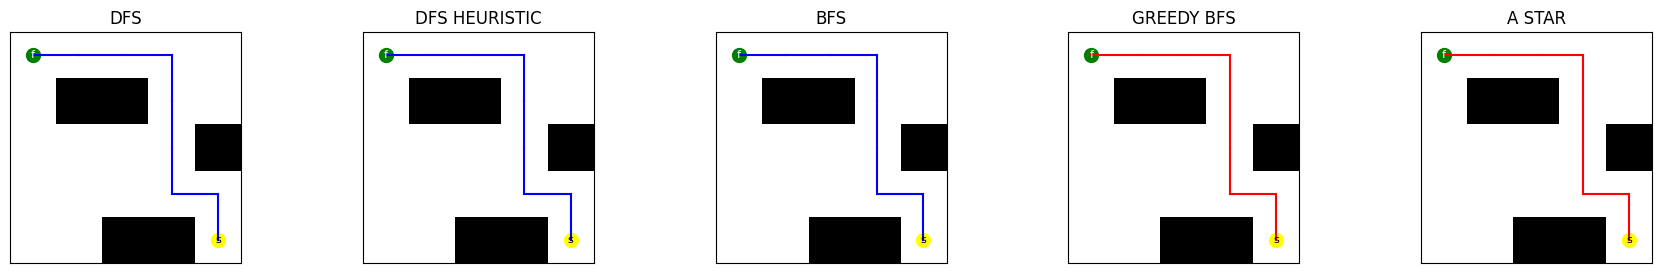

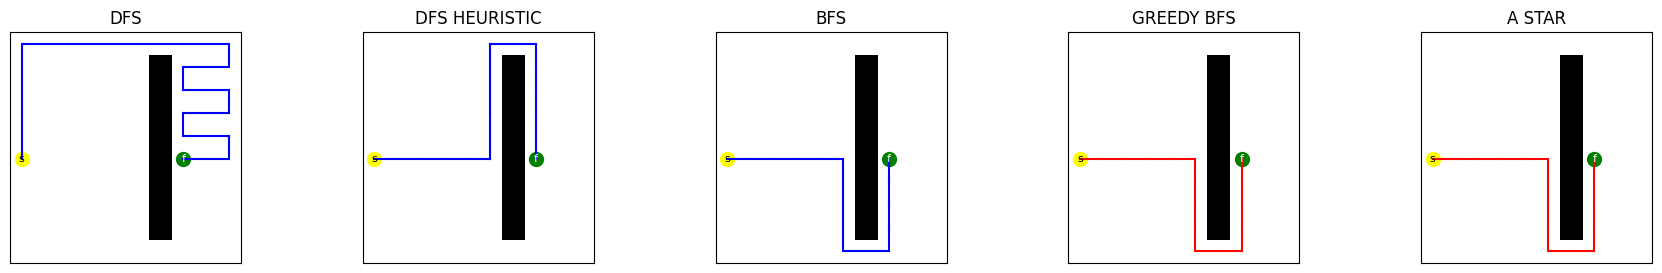

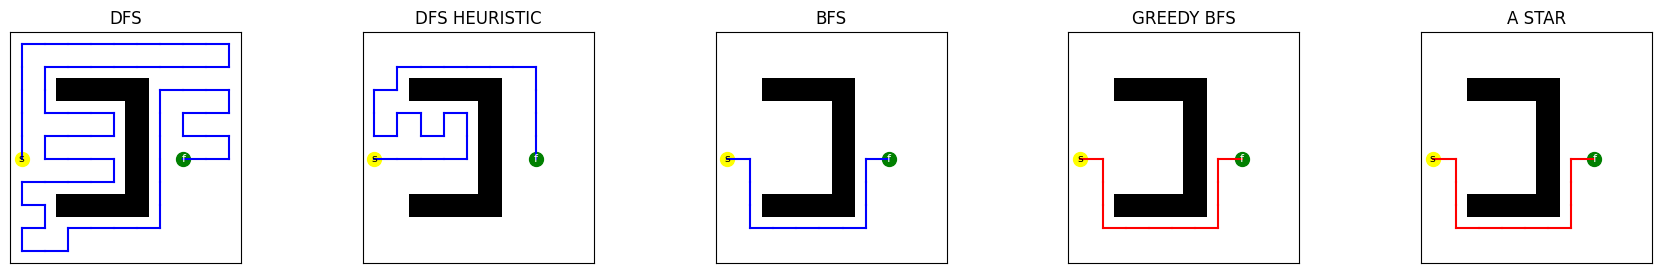

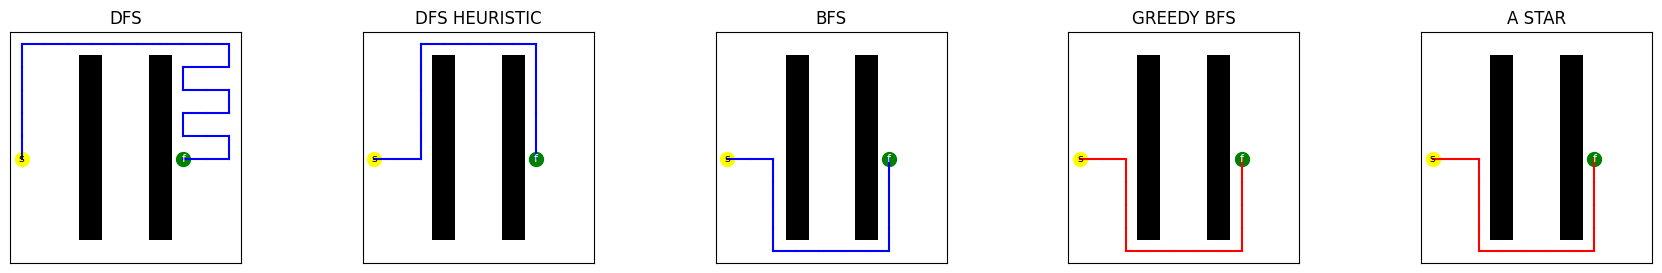

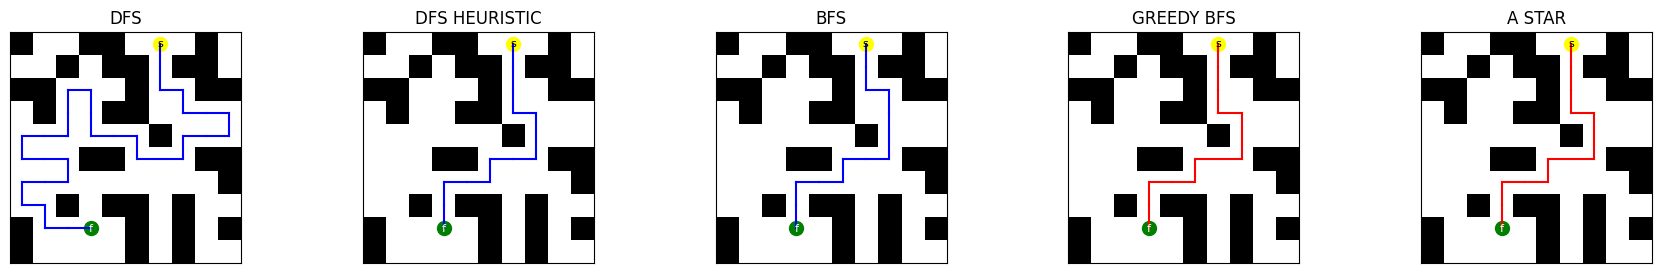

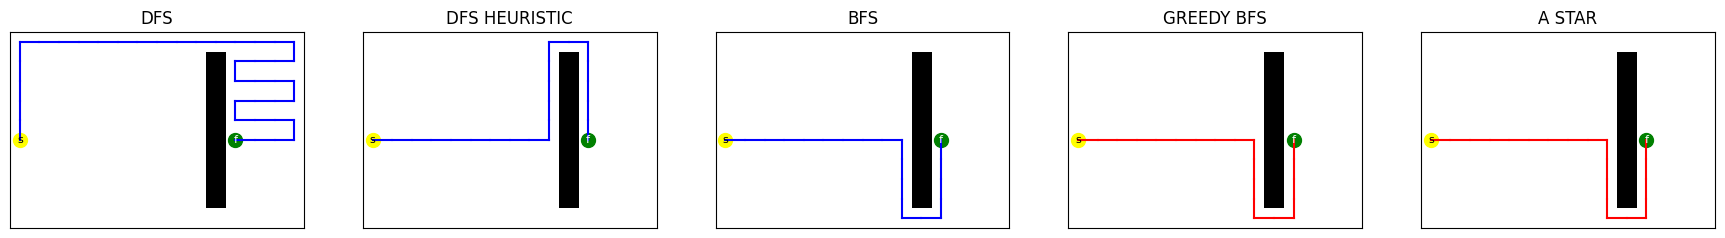

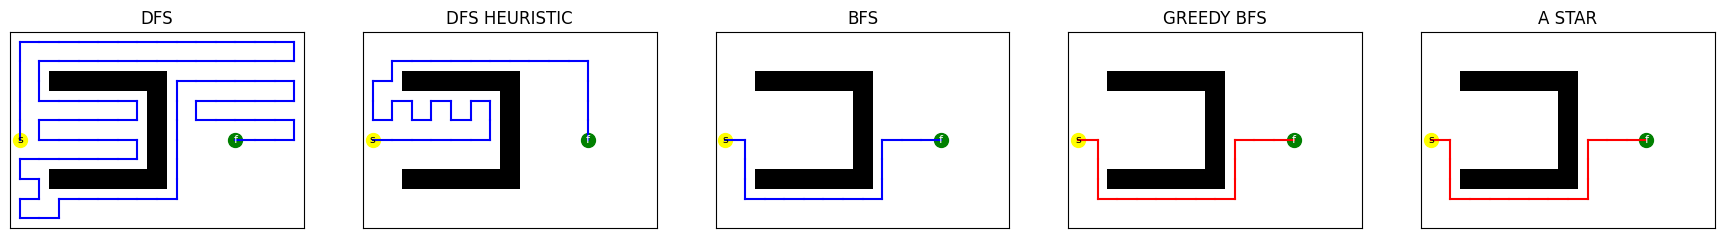

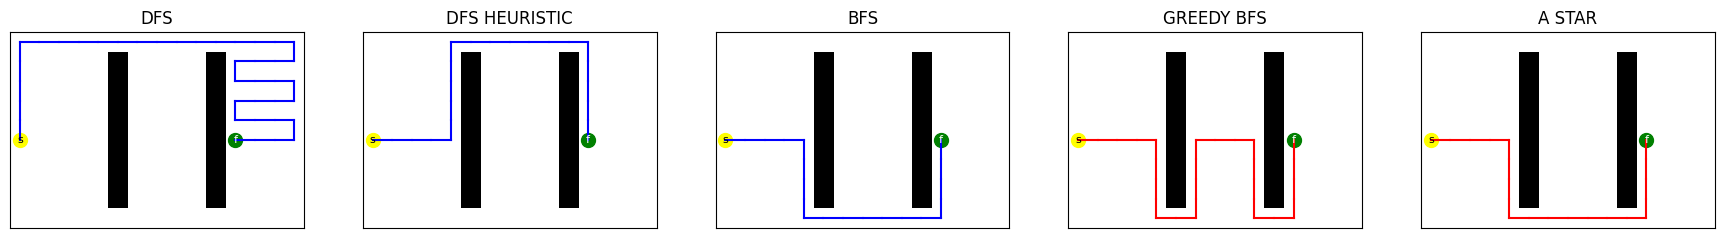

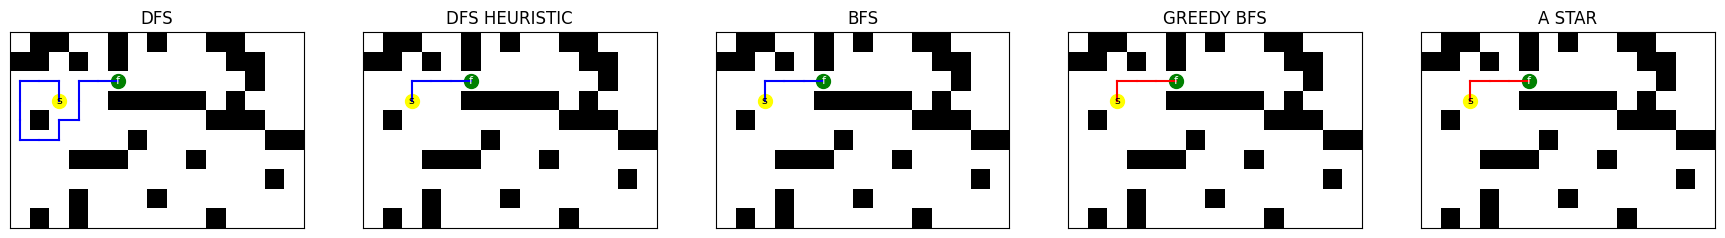

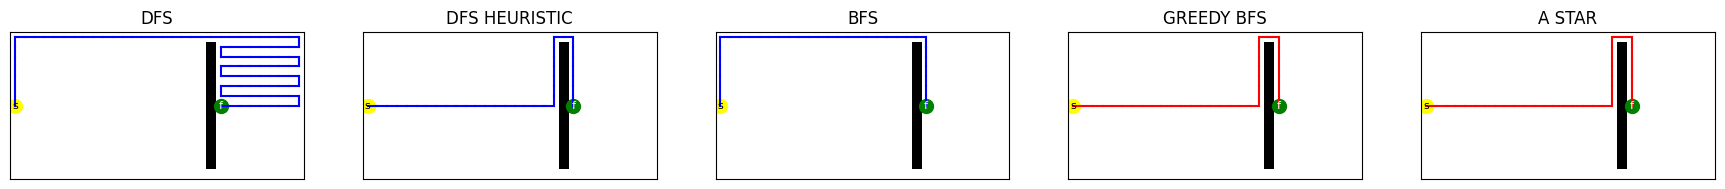

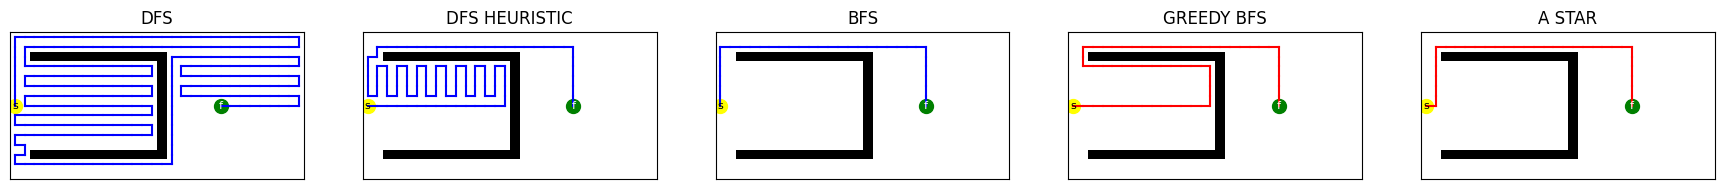

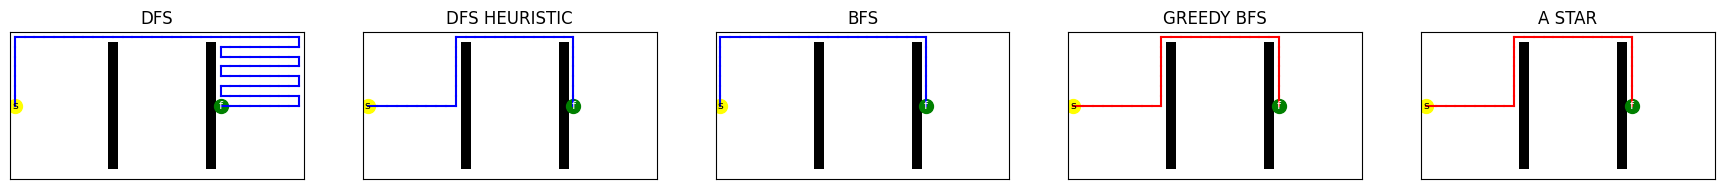

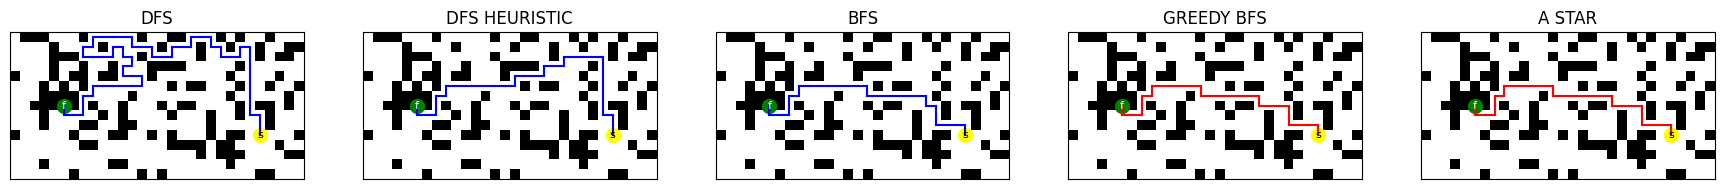

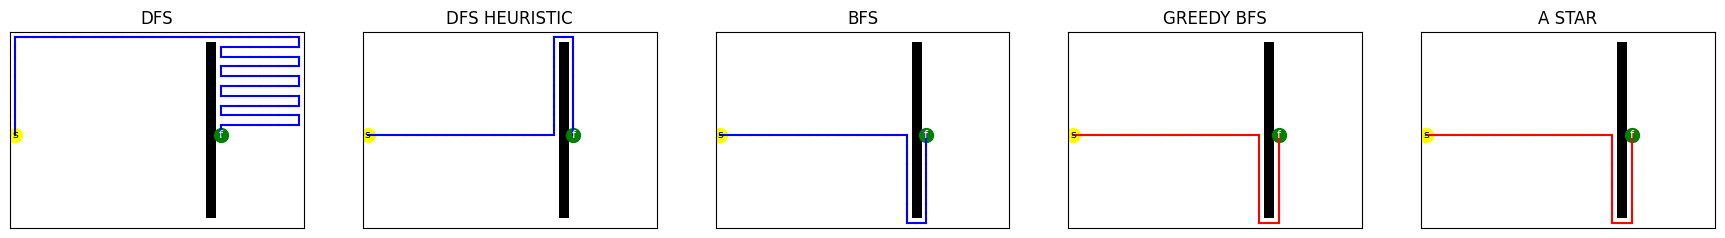

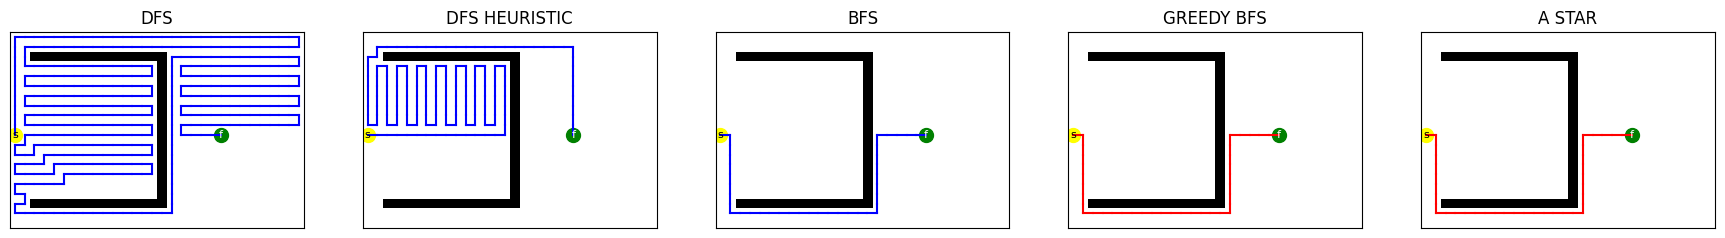

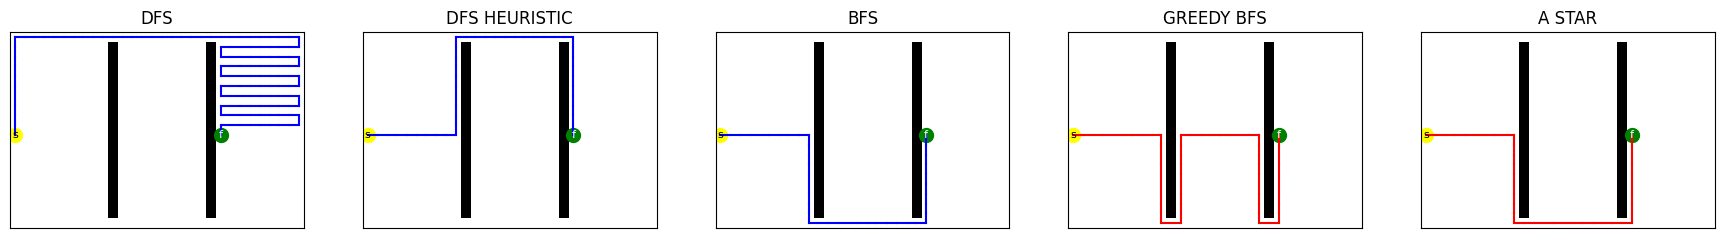

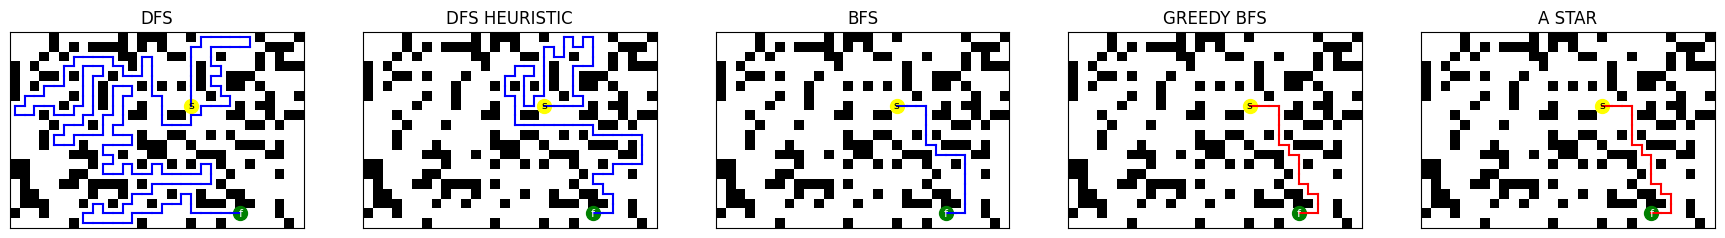

In [282]:
n = 500

datas = []

dimensions = [(5,5), (10,10), (10,15), (15,30), (20,30)]
percent_blockages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for (rows, cols) in dimensions:
    
    graph = Graph(rows=rows, cols=cols)

    for variant in [0,1,2]:
        data = {
            "percent": 0,
            "dimension": (rows, cols),
            "type": "fixed_" + str(variant),
            "dfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
            "a_star": {"time": 0, "iterations": 0, "length": 0},
        }
        graph.generate_grid(grid_type="fixed", variant=variant)

        dfs_path, dfs_complexity = graph.search(dfs)
        dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)
        bfs_path, bfs_complexity = graph.search(bfs)
        greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
        astar_path, astar_complexity = graph.search(a_star)

        data["dfs"]["time"] = dfs_complexity["time"]
        data["dfs"]["iterations"] = dfs_complexity["iterations"]
        data["dfs"]["length"] = dfs_complexity["length"]

        data["dfs_heur"]["time"] = dfs_heur_complexity["time"]
        data["dfs_heur"]["iterations"] = dfs_heur_complexity["iterations"]
        data["dfs_heur"]["length"] = dfs_heur_complexity["length"]

        data["bfs"]["time"] = bfs_complexity["time"]
        data["bfs"]["iterations"] = bfs_complexity["iterations"]
        data["bfs"]["length"] = bfs_complexity["length"]

        data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
        data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
        data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

        data["a_star"]["time"] = astar_complexity["time"]
        data["a_star"]["iterations"] = astar_complexity["iterations"]
        data["a_star"]["length"] = astar_complexity["length"]


        _, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))

        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
        plot_path(axes[0], dfs_path, c='blue',label='DFS')
        plot_path(axes[1], dfs_heur_path, c='blue',label='DFS HEURISTIC')
        plot_path(axes[2], bfs_path, c='blue',label='BFS')
        plot_path(axes[3], greedy_bfs_path, c='red',label='GREEDY BFS')
        plot_path(axes[4], astar_path, c='red',label='A STAR')

        plt.show()

        datas.append(data)

    for percent in percent_blockages:
        data = {
            "percent": percent,
            "dimension": (rows, cols),
            "type": "random",
            "dfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
            "a_star": {"time": 0, "iterations": 0, "length": 0},
        }
        for i in range(n):
            graph.generate_grid(grid_type="random", percent_blocked=percent)

            dfs_path, dfs_complexity = graph.search(dfs)
            dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)
            bfs_path, bfs_complexity = graph.search(bfs)
            greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
            astar_path, astar_complexity = graph.search(a_star)

            data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
            data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
            data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

            data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
            data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
            data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

            data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
            data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
            data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

            data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
            data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
            data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

            data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
            data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
            data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)

        if percent == 0.3:
            _, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))

            plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
            plot_path(axes[0], dfs_path, c='blue',label='DFS')
            plot_path(axes[1], dfs_heur_path, c='blue',label='DFS HEURISTIC')
            plot_path(axes[2], bfs_path, c='blue',label='BFS')
            plot_path(axes[3], greedy_bfs_path, c='red',label='GREEDY BFS')
            plot_path(axes[4], astar_path, c='red',label='A STAR')

            plt.show()

        datas.append(data)



In [283]:
data_df = {"percent": [], "type": [], "dimension": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    data_df["dimension"].append(d["dimension"])
    for k in ["time", "iterations", "length"]:
        for t in ["dfs", "dfs_heur", "bfs", "greedy_bfs", "a_star"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [284]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type', 'dimension'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                           \
                                dfs  dfs_heur       bfs greedy_bfs    a_star   
percent type    dimension                                                      
0.0     fixed_0 (5, 5)     0.000028  0.000025  0.000044   0.000026  0.000029   
        fixed_1 (5, 5)     0.000038  0.000021  0.000045   0.000023  0.000022   
        fixed_2 (5, 5)     0.000029  0.000024  0.000042   0.000027  0.000022   
        random  (5, 5)     0.000018  0.000011  0.000029   0.000014  0.000017   
0.1     random  (5, 5)     0.000017  0.000011  0.000028   0.000014  0.000016   
0.2     random  (5, 5)     0.000016  0.000012  0.000025   0.000014  0.000016   
0.3     random  (5, 5)     0.000015  0.000013  0.000022   0.000015  0.000016   
0.4     random  (5, 5)     0.000014  0.000014  0.000020   0.000015  0.000016   
0.5     random  (5, 5)     0.000012  0.000014  0.000018   0.000015  0.000015   
0.6     random  (5, 5)     0.000011  0.000013  0.000016   0.000014  0.000015   
0.0     fixed_0 (10, 10)   0.000033  0.000035  0.000143   0.000072  0.000125   
        fixed_1 (10, 10)   0.000096  0.000063  0.000142   0.000078  0.000081   
        fixed_2 (10, 10)   0.000070  0.000055  0.000216   0.000108  0.000100   
        random  (10, 10)   0.000062  0.000018  0.000097   0.000025  0.000038   
0.1     random  (10, 10)   0.000057  0.000019  0.000080   0.000024  0.000032   
0.2     random  (10, 10)   0.000054  0.000026  0.000076   0.000026  0.000034   
0.3     random  (10, 10)   0.000055  0.000038  0.000067   0.000032  0.000039   
0.4     random  (10, 10)   0.000042  0.000037  0.000053   0.000033  0.000038   
0.5     random  (10, 10)   0.000033  0.000036  0.000044   0.000032  0.000035   
0.6     random  (10, 10)   0.000024  0.000031  0.000035   0.000031  0.000032   
0.0     fixed_0 (10, 15)   0.000042  0.000041  0.000197   0.000083  0.000195   
        fixed_1 (10, 15)   0.000136  0.000083  0.000208   0.000108  0.000108   
        fixed_2 (10, 15)   0.000058  0.000052  0.000215   0.000134  0.000161   
        random  (10, 15)   0.000091  0.000020  0.000137   0.000030  0.000046   
0.1     random  (10, 15)   0.000084  0.000023  0.000117   0.000029  0.000041   
0.2     random  (10, 15)   0.000083  0.000037  0.000104   0.000032  0.000043   
0.3     random  (10, 15)   0.000074  0.000055  0.000094   0.000041  0.000052   
0.4     random  (10, 15)   0.000062  0.000057  0.000075   0.000046  0.000053   
0.5     random  (10, 15)   0.000044  0.000048  0.000056   0.000041  0.000045   
0.6     random  (10, 15)   0.000032  0.000042  0.000044   0.000038  0.000041   
0.0     fixed_0 (15, 30)   0.000108  0.000069  0.000596   0.000166  0.000578   
        fixed_1 (15, 30)   0.000359  0.000210  0.000591   0.000339  0.000415   
        fixed_2 (15, 30)   0.000128  0.000076  0.000616   0.000174  0.000477   
        random  (15, 30)   0.000247  0.000033  0.000379   0.000050  0.000096   
0.1     random  (15, 30)   0.000237  0.000037  0.000324   0.000048  0.000091   
0.2     random  (15, 30)   0.000236  0.000071  0.000294   0.000054  0.000097   
0.3     random  (15, 30)   0.000242  0.000133  0.000241   0.000073  0.000117   
0.4     random  (15, 30)   0.000167  0.000158  0.000184   0.000101  0.000133   
0.5     random  (15, 30)   0.000101  0.000125  0.000125   0.000094  0.000106   
0.6     random  (15, 30)   0.000060  0.000083  0.000084   0.000074  0.000078   
0.0     fixed_0 (20, 30)   0.000129  0.000079  0.000787   0.000254  0.000793   
        fixed_1 (20, 30)   0.000501  0.000308  0.000875   0.000481  0.000513   
        fixed_2 (20, 30)   0.000158  0.000088  0.000860   0.000463  0.000669   
        random  (20, 30)   0.000319  0.000036  0.000501   0.000056  0.000118   
0.1     random  (20, 30)   0.000307  0.000045  0.000441   0.000055  0.000116   
0.2     random  (20, 30)   0.000302  0.000076  0.000385   0.000059  0.000109   
0.3     random  (20, 30)   0.000295  0.000152  0.000328   0.000085  0.000144   
0.4     random  (20, 30)   0.00

## Let's see these in action on the fixed grid variants

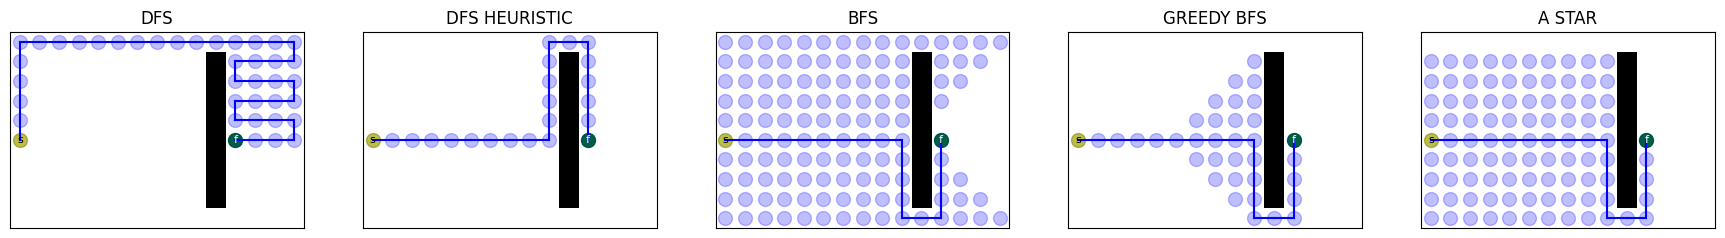

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
dfs
a_star
bfs


In [302]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=0)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

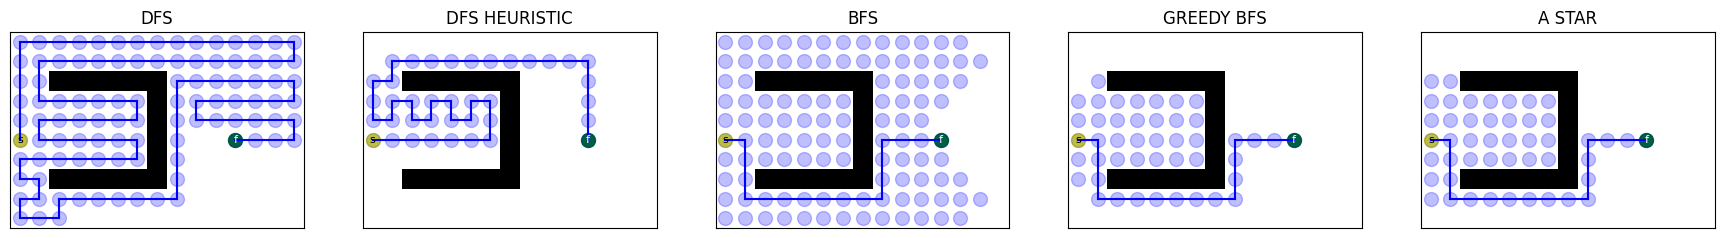

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [303]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=1)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

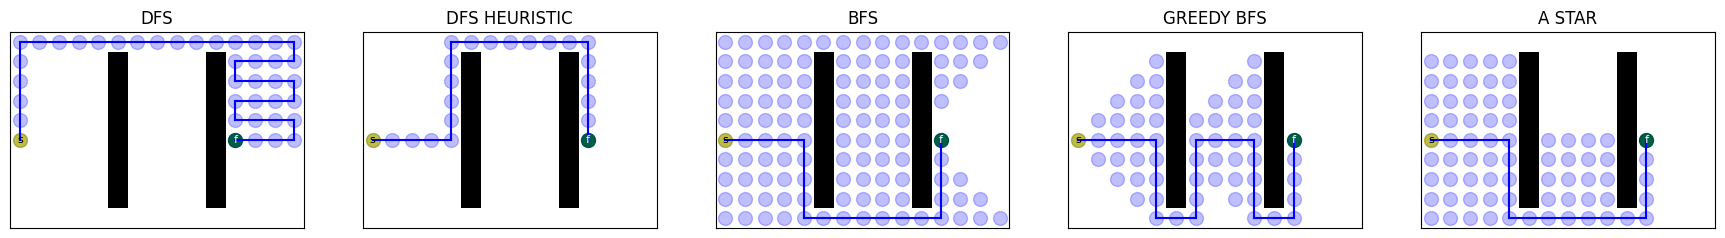

ORDER (fast to slow):
dfs_heuristic
dfs
greedy_bfs
a_star
bfs


In [304]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=2)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

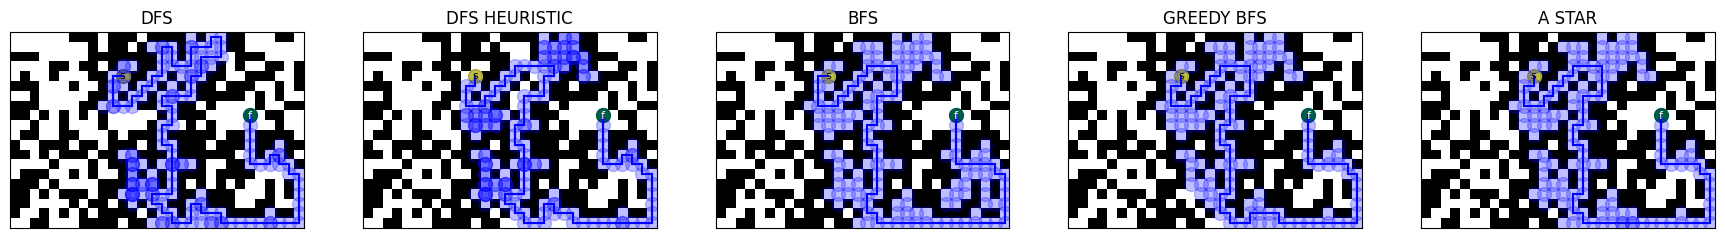

ORDER (fast to slow):
greedy_bfs
a_star
bfs
dfs
dfs_heuristic


In [305]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random", percent_blocked=0.5)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()